## PROJECT 32: Population Time Series Data

> ### TASK: Stady dense neural network for forecasting time series


### Project goals and objectives

#### Project goal

- Studying **Dense neural network for forecasting time series**

#### Project objectives

1. Explore and prepare data 
2. Building dense model

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')

import re
import math as math

import tensorflow as tf

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError


from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import Regularizer

import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### LOAD DATA

In [2]:
# Path to data
data_path = "data/POP.csv"

In [3]:
# Load the data
data = pd.read_csv(data_path, parse_dates=['date'], index_col=['date'])

# Check result 
data.head()

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06


In [4]:
# Drop columns
data.drop(["realtime_start", "realtime_end"], axis=1,inplace=True)

# Check result 
data.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


### EXPLORATORY DATA ANALYSIS 

In [5]:
# Check the missing values
print("Check the number of records")
print("Number of records: ", data.shape[0], "\n")

print("Null analysis")
empty_sample = data[data.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")

Check the number of records
Number of records:  816 

Null analysis
Number of records contain 1+ null:  0 



In [6]:
data.shape

(816, 1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


#### Distribution analysis

In [8]:
def distribution(data_for_eda):
    
    fig, ax = plt.subplots(1,3, figsize=(25, 5))
    fig.subplots_adjust(wspace=0.15)
    plt.suptitle("Distribution of observations", fontsize=18)
    
    sns.set_style("whitegrid")
    sns.histplot(data = data_for_eda, bins = 20, stat = 'density', kde = False, ax=ax[0])
    sns.boxenplot(data = data_for_eda, ax=ax[1])
    sns.ecdfplot(data = data_for_eda, ax=ax[2])
    
    fig, ax = plt.subplots(1,1, figsize=(25, 5))
    plt.plot(data_for_eda)
    plt.title("Montly Value", fontsize=18)
    
    print("Descriptive statistics:\n{}\n".format(data_for_eda.describe().round(2)) + '_' * 100+ '\n')
    print("Skew:\n{}\n".format(data_for_eda.skew().round(2))+ '_' * 100+ '\n')
    print("Kurtosis:\n{}\n".format(data_for_eda.kurt().round(2)) + '_' * 100+ '\n')

Descriptive statistics:
           value
count     816.00
mean   243847.77
std     50519.14
min    156309.00
25%    201725.25
50%    239557.50
75%    289364.25
max    330309.95
____________________________________________________________________________________________________

Skew:
value    0.08
dtype: float64
____________________________________________________________________________________________________

Kurtosis:
value   -1.19
dtype: float64
____________________________________________________________________________________________________



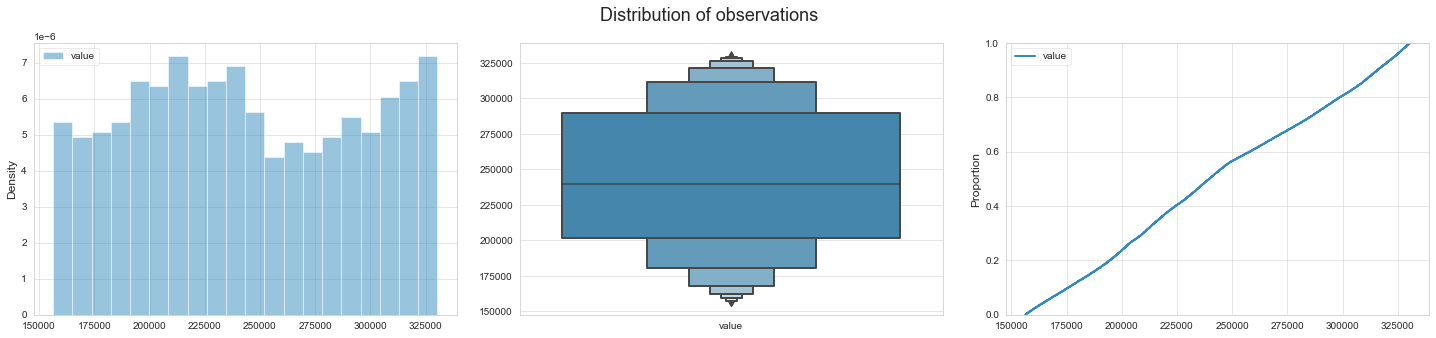

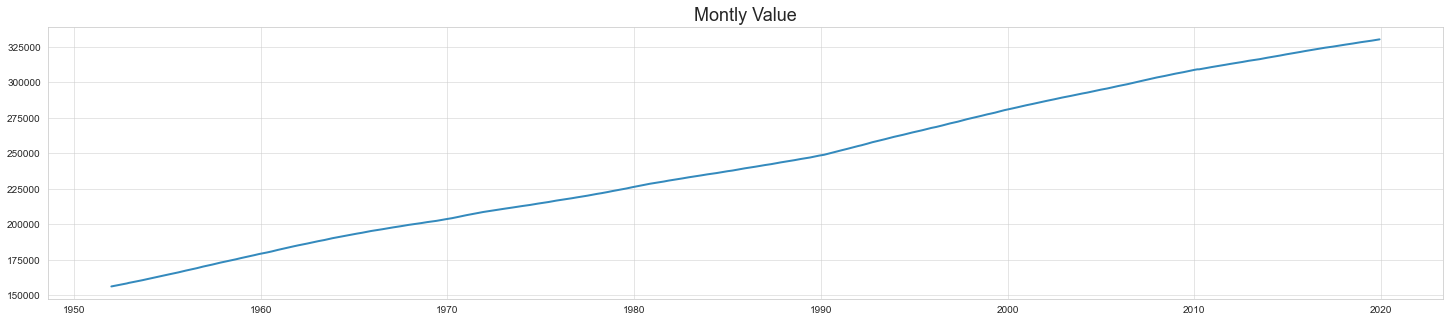

In [9]:
distribution(data)

#### Trend analysis

In [10]:
def trend_analysis(data_for_eda):
    # BUILDING MOVING AVERAGES
    
    # 7-day moving average
    data_7d_rol = data_for_eda.rolling(window = 7, center = True).mean()

    # 30-day moving average
    data_30d_rol = data_for_eda.rolling(window = 30, center = True).mean()

    # 365-day moving average
    data_365d_rol = data_for_eda.rolling(window = 365, center = True).mean()
    
    #PLOTTING MOVING AVERAGES
    
    fig, ax = plt.subplots(figsize = (20,5))

    # plotting daily data
    ax.plot(data_for_eda, marker='*', markersize=2, color='0.6',linestyle='None', label='Daily')

    # A fallback version of the presentation
    # ax.plot(novaya_entering_t2, linewidth=2, label='Daily', color='0.6', alpha = 0.5 )

    # plotting 7-day rolling data
    ax.plot(data_7d_rol, linewidth=2, label='7-d Rolling Mean')

    # plotting 30-day rolling data
    ax.plot(data_30d_rol, linewidth=2, label='30-d Rolling Mean')

    # plotting annual rolling data
    ax.plot(data_365d_rol, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean)')

        
    # Beautification of plot
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('People')
    ax.set_title('Trends in series', fontsize=18)

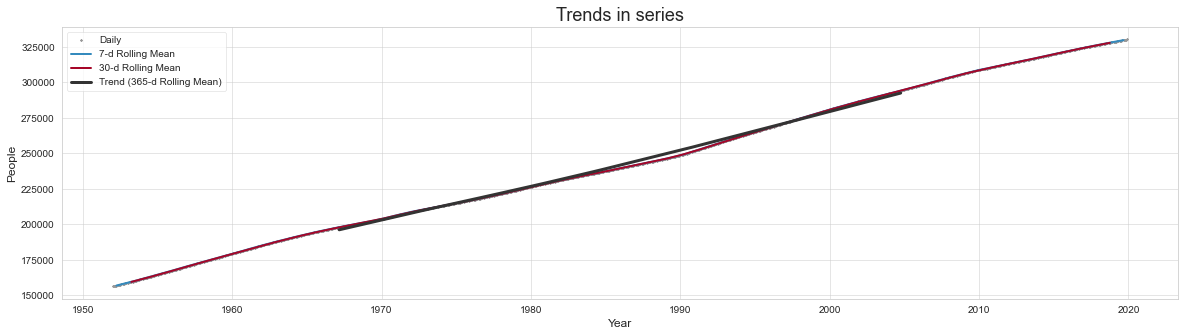

In [11]:
trend_analysis(data)

#### Autocorrelation analysis

In [12]:
def autocorr_analysis(data_for_eda):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3), dpi= 100)
    plt.suptitle("Autocorrelation analysis", fontsize=18)
    
    sm.graphics.tsa.plot_acf(data_for_eda.values.squeeze(), lags=50, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data_for_eda.values.squeeze(), lags=50, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(figsize=(19.7, 3), dpi= 100)
    pd.plotting.autocorrelation_plot(data_for_eda, ax=ax)
    plt.show()

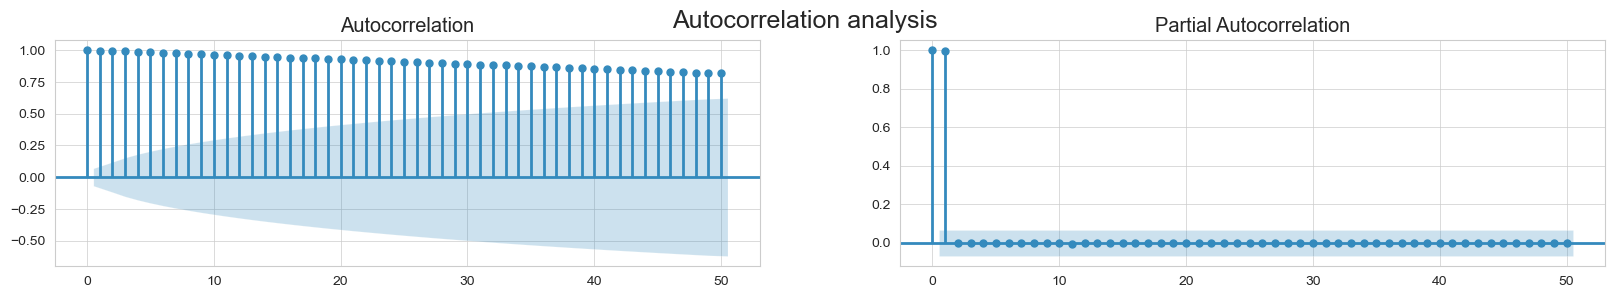

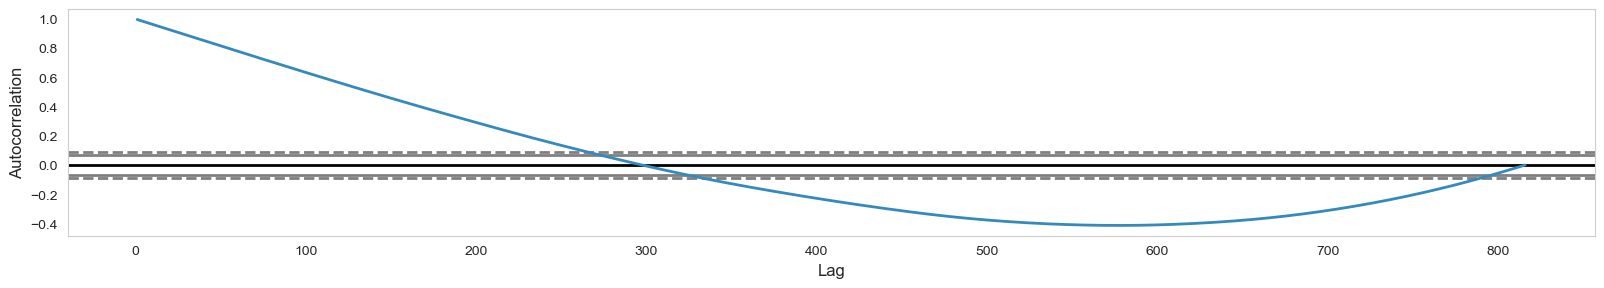

In [13]:
autocorr_analysis(data)

#### Analysis of seasonality

In [14]:
def seasonality_analysis(data_for_eda, period=365):
    seasonality = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period).seasonal
    fig, ax = plt.subplots(figsize = (20,5))
    ax.plot(seasonality)          

In [15]:
def decomposition(data_for_eda):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,5
        
    decomposition = sm.tsa.seasonal_decompose(data_for_eda, model='additive')
    
    decomposition.plot()
    plt.suptitle("Decomposition", fontsize=18)

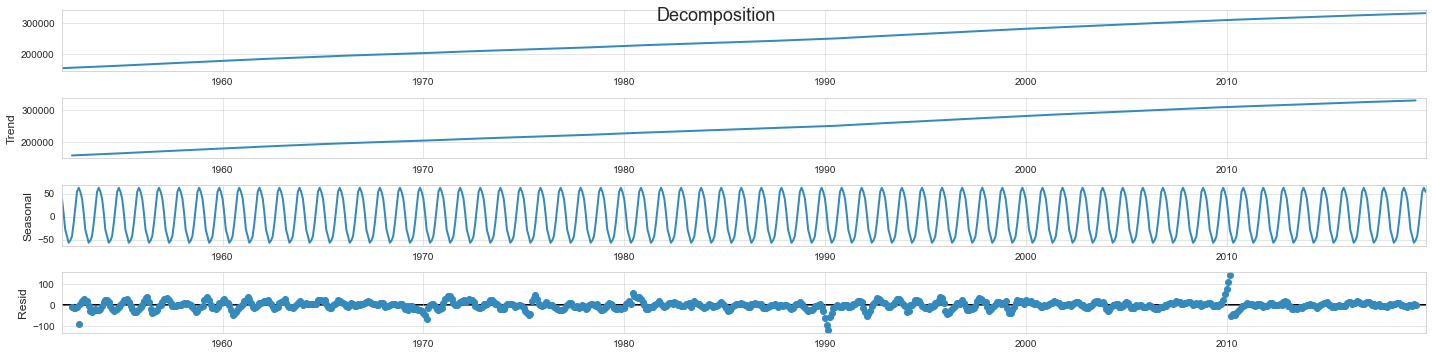

In [16]:
decomposition(data)

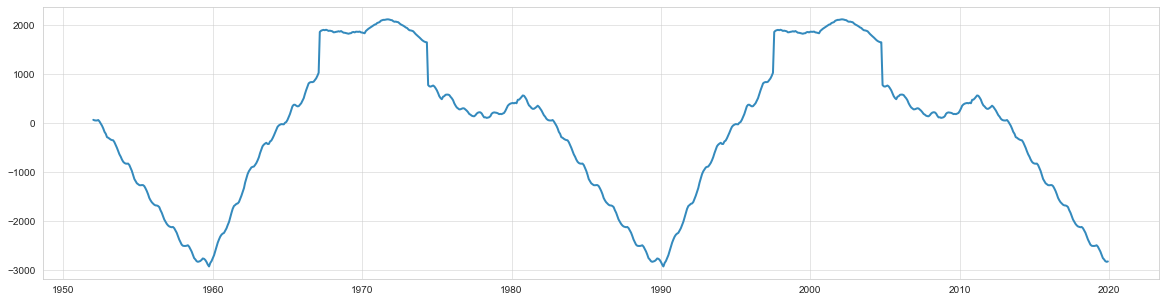

In [17]:
seasonality_analysis(data, period=365)

#### Analysis of stationarity

In [18]:
def stationarity_analysis(data_for_eda):
    test = sm.tsa.adfuller(data_for_eda)
    print ('adf:', test[0])
    print ('p-value:', test[1])
    print ('Critical values:', test[4])
    if test[0]> test[4]['5%']: 
        print ('\n There are single roots, the row is not stationary')
    else:
        print ('\n There are no single roots, the row is STATIONARY')

In [19]:
stationarity_analysis(data)

adf: -0.6653174110244149
p-value: 0.8555297778919547
Critical values: {'1%': -3.4385711275998583, '5%': -2.8651686574447375, '10%': -2.568702230639255}

 There are single roots, the row is not stationary


### DATA PREPARATION 

#### Split the data (70%, 20%, 10%)

In [27]:
n = len(data)

train_df = data[0:int(n*0.7)]

val_df = data[int(n*0.7):int(n*0.9)]

test_df = data[int(n*0.9):]

len(train_df), len(val_df), len(test_df)

(571, 163, 82)

#### Data windowing

In [28]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [29]:
win = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['value'])
win

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['value']

#### Split

In [30]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:win.total_window_size]),
                           np.array(train_df[100:100+win.total_window_size]),
                           np.array(train_df[200:200+win.total_window_size])])

example_inputs, example_labels = win.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


2021-11-09 01:46:18.160863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 01:46:18.170714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 01:46:18.171701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 01:46:18.173423: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

#### Create `tf.data.Datasets`

In [32]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [34]:
# Each element is an (inputs, label) pair.
win.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
for example_inputs, example_labels in win.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


2021-11-09 01:46:18.923841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### DENSE MODELS

### Model 1 (window = 7, horizon = 1)

In [36]:

input = Input(shape=(6, 1), name='model_1')

# Deep branch 1
branch_11 = Dense(256, activation='relu', kernel_regularizer='l1')(input)
dropout = Dropout(rate=0.3)(branch_11)
bach_norm = BatchNormalization()(dropout)

branch_12 = Dense(128, activation='relu', kernel_regularizer='l1')(bach_norm)
dropout = Dropout(rate=0.3)(branch_12)
out_branch_1 = BatchNormalization()(dropout)

# Deep branch 2
branch_21 = Dense(256, activation='relu', kernel_regularizer='l2')(input)
dropout = Dropout(rate=0.3)(branch_21)
bach_norm = BatchNormalization()(dropout)

branch_22 = Dense(512, activation='relu', kernel_regularizer='l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_22)
bach_norm = BatchNormalization()(dropout)

branch_23 = Dense(256, activation='relu', kernel_regularizer='l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_23)
bach_norm = BatchNormalization()(dropout)

branch_24 = Dense(256, activation='relu', kernel_regularizer='l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_24)
out_branch_2 = BatchNormalization()(dropout)

# Deep branch 3
branch_31 = Dense(128, activation='relu', kernel_regularizer='l1_l2')(input)
dropout = Dropout(rate=0.3)(branch_31)
bach_norm = BatchNormalization()(dropout)

branch_32 = Dense(256, activation='relu', kernel_regularizer='l1_l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_32)
bach_norm = BatchNormalization()(dropout)

branch_33 = Dense(512, activation='relu', kernel_regularizer='l1_l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_33)
bach_norm = BatchNormalization()(dropout)

branch_34 = Dense(512, activation='relu', kernel_regularizer='l1_l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_34)
bach_norm = BatchNormalization()(dropout)

branch_35 = Dense(256, activation='relu', kernel_regularizer='l1_l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_35)
bach_norm = BatchNormalization()(dropout)

branch_36 = Dense(128, activation='relu', kernel_regularizer='l1_l2')(bach_norm)
dropout = Dropout(rate=0.3)(branch_36)
out_branch_3 = BatchNormalization()(dropout)

concat = Concatenate()([input, out_branch_1, out_branch_2, out_branch_3])
output = Dense(1, activation='linear')(concat)

model_1 = Model(inputs=input, outputs=output, name='model_1')

model_1.compile(optimizer='Adam',
                  loss='mae',
                  metrics=['mae'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_1 (InputLayer)            [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 6, 128)       256         model_1[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 6, 128)       0           dense_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 6, 128)       512         dropout_6[0][0]                  
____________________________________________________________________________________________

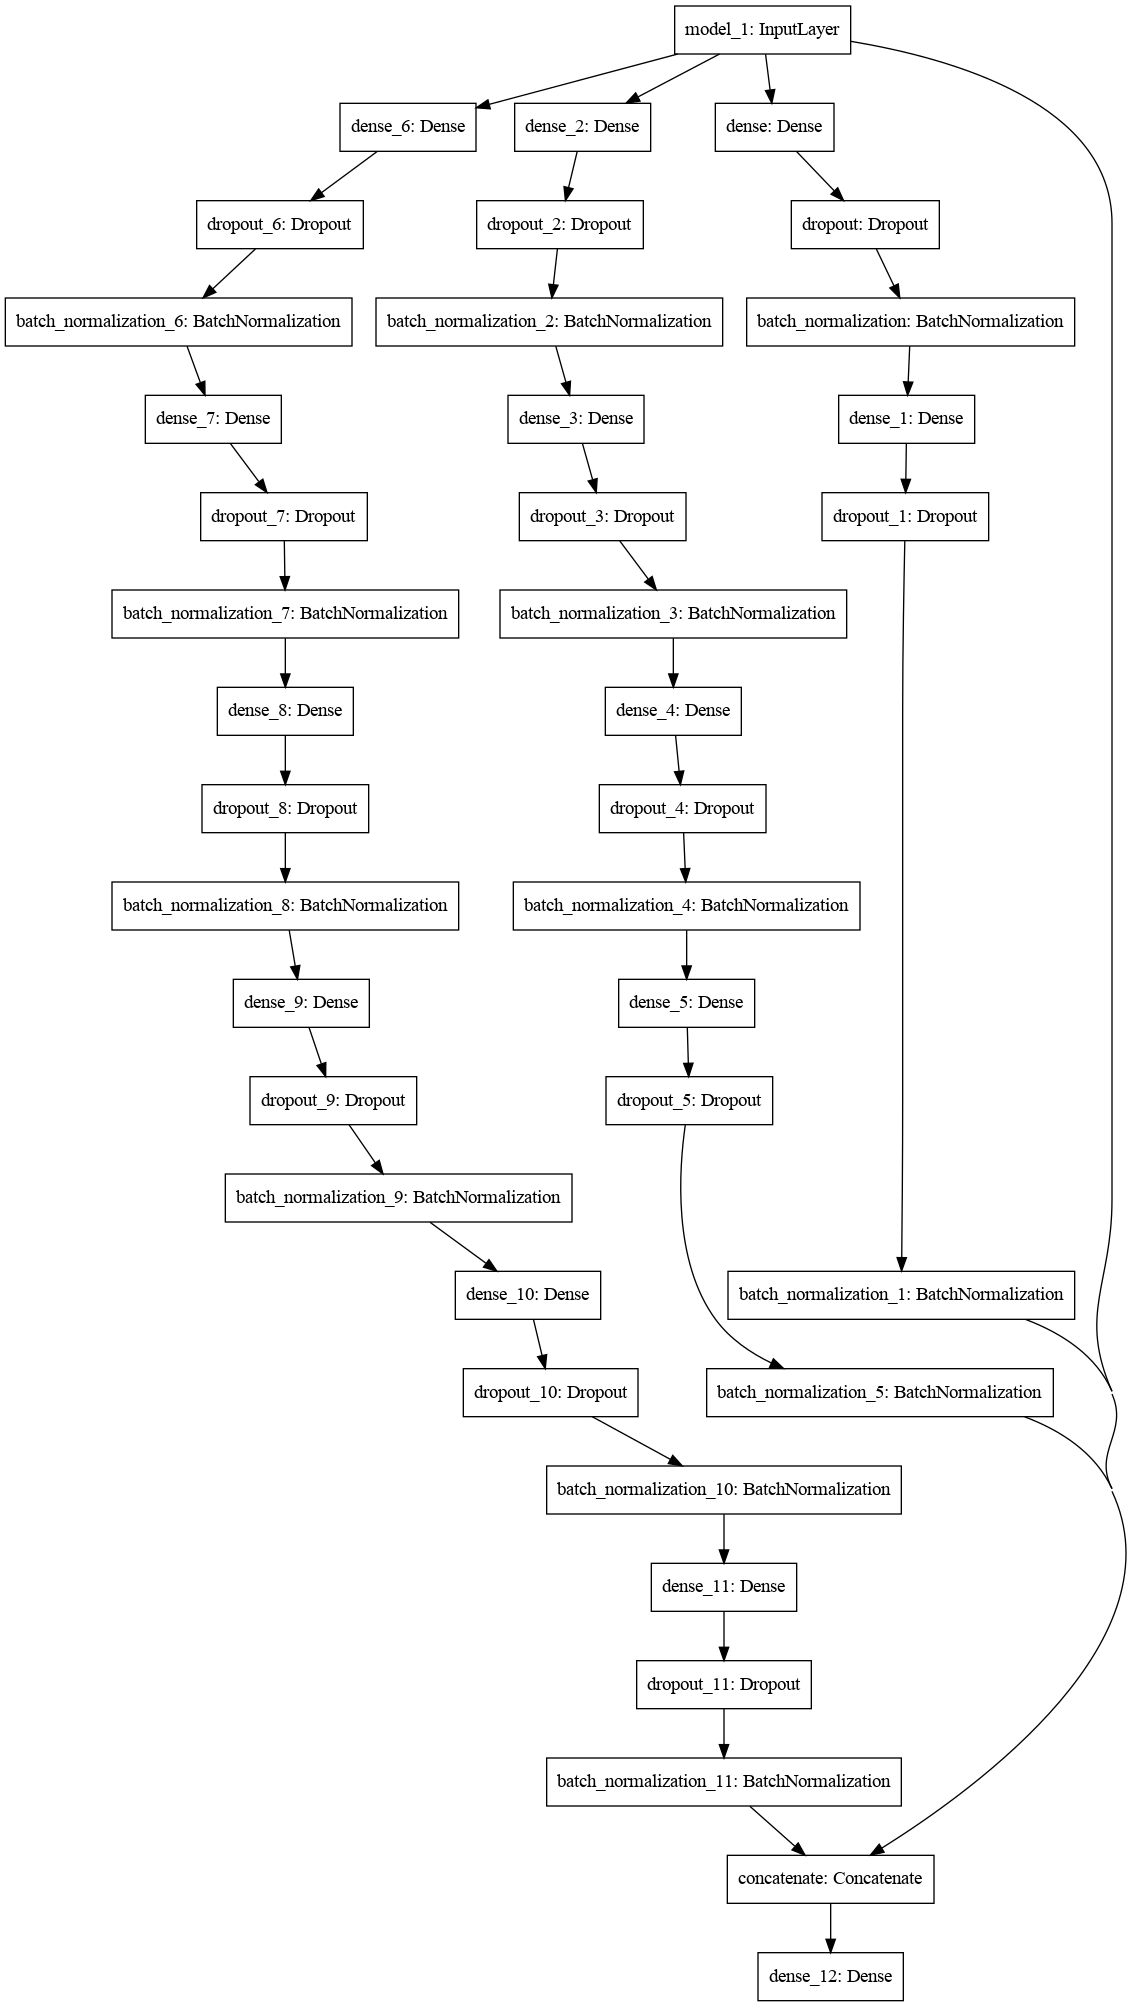

In [37]:
model_1.summary()
tf.keras.utils.plot_model(model_1, to_file='model_1.png')

In [38]:
MAX_EPOCHS = 155

def compile_and_fit(model, window, patience=2):
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_1.h5",
                                                        save_best_only=True)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=patience,
                                                         restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(win.train, epochs=MAX_EPOCHS,
                        validation_data=win.val,
                        callbacks=[checkpoint_cb,
                                   early_stopping_cb])
    return history

In [39]:
history = compile_and_fit(model_1, win)

Epoch 1/155
18/18 [==============================] - 4s 56ms/step - loss: 51920371712.0000 - mean_absolute_error: 225252.2969 - val_loss: 93944889344.0000 - val_mean_absolute_error: 306328.1250
Epoch 2/155
18/18 [==============================] - 0s 23ms/step - loss: 50145927168.0000 - mean_absolute_error: 221378.1562 - val_loss: 90225754112.0000 - val_mean_absolute_error: 300203.5312
Epoch 3/155
18/18 [==============================] - 0s 24ms/step - loss: 48417206272.0000 - mean_absolute_error: 217521.0312 - val_loss: 87828299776.0000 - val_mean_absolute_error: 296188.2500
Epoch 4/155
18/18 [==============================] - 0s 23ms/step - loss: 46726393856.0000 - mean_absolute_error: 213688.3281 - val_loss: 84706508800.0000 - val_mean_absolute_error: 290876.7812
Epoch 5/155
18/18 [==============================] - 0s 23ms/step - loss: 45076684800.0000 - mean_absolute_error: 209896.8594 - val_loss: 81271889920.0000 - val_mean_absolute_error: 284918.8125
Epoch 6/155
18/18 [===========

In [40]:
# Evaluation and visualization of model parameters

def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="loss (mse) for training")
    axL.plot(history.history['val_loss'], label="loss (mse) for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['mean_absolute_error'], label="mean absolute error for training")
    axR.plot(history.history['val_mean_absolute_error'], label="mean absolute error for validation")
    axR.set_title('model mae')
    axR.set_xlabel('epoch')
    axR.set_ylabel('mae')
    axR.legend(loc='upper right')

    plt.show()

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("People")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)


def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

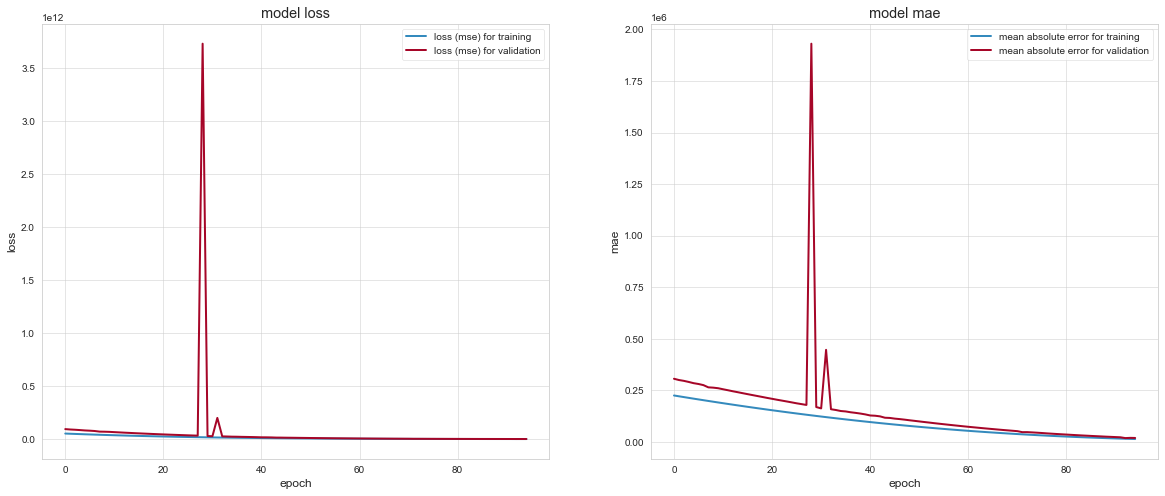

In [42]:
# Evaluation model
evaluation_model(history)

In [43]:
# Evaluate model on test data
model_1.evaluate(win.test)

3/3 [==============================] - 0s 8ms/step - loss: 375116032.0000 - mean_absolute_error: 19365.3008


[375116032.0, 19365.30078125]

In [44]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_1.h5")
model_1.evaluate(win.test)

3/3 [==============================] - 1s 8ms/step - loss: 375116000.0000 - mean_absolute_error: 19365.3008


[375116000.0, 19365.30078125]

In [45]:
# Make predictions using model_1 on the test dataset
model_1_preds = make_preds(model_1, test_df)
len(model_1_preds)

82

In [46]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_df),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 18732.646,
 'mse': 350926300.0,
 'rmse': 18733.027,
 'mape': 5.7964697,
 'mase': 103.58913}